In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

# EDA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Pre-processing

### Remove listing_id  
#### listing_id is all unique without duplicates

In [3]:
train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

# train = train.drop(columns=['property_details_url', 'elevation','property_name','address','title'])

In [4]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price
count,19332.000000,20174.000000,19820.000000,2.025400e+04,14602.000000,20254.000000,20254.000000,2.025400e+04
mean,2010.833695,3.122931,2.643542,1.854364e+03,376.253938,1.434282,103.855356,5.228263e+06
std,15.822803,1.281658,1.473835,1.354343e+04,346.882474,1.558472,3.593441,2.779748e+08
min,1963.000000,1.000000,1.000000,0.000000e+00,4.000000,1.239621,-77.065364,0.000000e+00
25%,2000.000000,2.000000,2.000000,8.070000e+02,106.000000,1.307329,103.806576,8.190000e+05
50%,2017.000000,3.000000,2.000000,1.119000e+03,296.000000,1.329266,103.841552,1.680000e+06
75%,2023.000000,4.000000,3.000000,1.528000e+03,561.000000,1.372461,103.881514,3.242400e+06
max,2028.000000,10.000000,10.000000,1.496000e+06,2612.000000,69.486768,121.023232,3.924243e+10


### Adding Distances

#### Add distance to commericial centres

In [5]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [6]:
# vectorized haversine function
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [7]:
# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(train, ccdistance, on = 'planning_area')
expected_result.head()
train['cc_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
expected_result.head()
test['cc_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [8]:
ccdistancemean = train['cc_distance'].median()
train['cc_distance']=train['cc_distance'].fillna(ccdistancemean)

ccdistancemean = test['cc_distance'].median()
test['cc_distance']=test['cc_distance'].fillna(ccdistancemean)

#### Add distance to mrt stations

In [9]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(train, mrtdistance, on = 'planning_area')
train['mrt_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])


# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
test['mrt_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [10]:
mrtdistancemedian = train['mrt_distance'].median()
train['mrt_distance']=train['mrt_distance'].fillna(mrtdistancemedian)

mrtdistancemedian = test['mrt_distance'].median()
test['mrt_distance']=test['mrt_distance'].fillna(mrtdistancemedian)

#### Add distance to primary school 

In [11]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(train, primaryschooldistance, on = 'planning_area')
train['primary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
test['primary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [12]:
pschoolmedian = train['primary_school_distance'].median()
train['primary_school_distance'] = train['primary_school_distance'].fillna(pschoolmedian)

pschoolmedian = test['primary_school_distance'].median()
test['primary_school_distance'] = test['primary_school_distance'].fillna(pschoolmedian)

#### Add distance to secondary school

In [13]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['secondary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['secondary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [14]:
sschooldistance = train['secondary_school_distance'].median()
train['secondary_school_distance'] = train['secondary_school_distance'].fillna(sschooldistance)

sschooldistance = test['secondary_school_distance'].median()
test['secondary_school_distance'] = test['secondary_school_distance'].fillna(sschooldistance)

#### Add distance to shopping malls

In [15]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['shop_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['shop_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [16]:
sdistancemedian = train['shop_distance'].median()
train['shop_distance'] = train['shop_distance'].fillna(sdistancemedian)

sdistancemedian = test['shop_distance'].median()
test['shop_distance'] = test['shop_distance'].fillna(sdistancemedian)

In [17]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,1.414399,103.837196,yishun south,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,1.372597,103.875625,serangoon north,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,103.895798,mountbatten,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,103.803271,farrer court,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,103.843635,anson,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600


### Population

In [18]:
population = pd.read_csv('auxiliary-data/sg-subzones.csv')

In [19]:
expected_result = pd.merge(train, population, on = 'planning_area')
train['population'] = expected_result['population']
train['area_size'] = expected_result['area_size']

In [20]:
expected_result = pd.merge(test, population, on = 'planning_area')
test['population'] = expected_result['population']
test['area_size'] = expected_result['area_size']

In [21]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,...,yishun south,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,...,serangoon north,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,...,mountbatten,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,...,farrer court,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,...,anson,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


### Property Type cleaning

In [22]:
#Change all to uppercase
train['property_type']=train['property_type'].str.upper()

#Change all to uppercase
test['property_type']=test['property_type'].str.upper()

In [23]:
#for regression only
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(train['property_type'])
# train['property_type']=le.transform(train['property_type'])

# test['property_type']=le.transform(test['property_type'])

# one hot endcoding
# pd.get_dummies(train.property_type, prefix='property')

### Tenure 

In [24]:
train['tenure'] = train['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

train['tenure'] = train['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)



test['tenure'] = test['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

test['tenure'] = test['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)

In [25]:
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [26]:
train['tenure'] = train['tenure'].fillna('99-year leasehold')

In [27]:
## Remove NA 
train = train.dropna(subset=['tenure'])

## Remove NA 
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [28]:
#for regression only

# from sklearn import preprocessing
# tenurepp = preprocessing.LabelEncoder()
# tenurepp.fit(train['tenure'])
# train['tenure']=tenurepp.transform(train['tenure'])

# test['tenure']=tenurepp.transform(test['tenure'])

### Funishing

In [29]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

In [30]:
#for regression only

# from sklearn import preprocessing
# furnishing = preprocessing.LabelEncoder()
# furnishing.fit(train['furnishing'])
# train['furnishing']=furnishing.transform(train['furnishing'])

# test['furnishing']=furnishing.transform(test['furnishing'])

### floor_level 

In [31]:
# Too few data for floor level, we should just take out the column
train = train.drop(columns='floor_level')

# Too few data for floor level, we should just take out the column
test = test.drop(columns='floor_level')

### total_num_units

In [32]:
mediantotalunit = train['total_num_units'].median()
train['total_num_units'].fillna(mediantotalunit, inplace=True)

mediantotalunit = test['total_num_units'].median()
test['total_num_units'].fillna(mediantotalunit, inplace=True)

### build year

In [33]:
avgbuildyear = round(train['built_year'].median(),0)
train['built_year'] = train['built_year'].fillna(avgbuildyear)

avgbuildyear = round(test['built_year'].median(),0)
test['built_year'] = test['built_year'].fillna(avgbuildyear)

### num_baths

In [34]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB 4 ROOMS,99-year leasehold,1988.0,3.0,2.0,1115,unfurnished,NaN,116.0,1.414399,...,yishun south,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992.0,4.0,2.0,1575,unfurnished,"1, 2, 3, 4, 5, 6 br",296.0,1.372597,...,serangoon north,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,CONDO,freehold,2022.0,4.0,6.0,3070,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,...,mountbatten,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023.0,3.0,2.0,958,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,...,farrer court,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026.0,2.0,1.0,732,unfurnished,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,...,anson,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


In [35]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types          object
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

In [36]:
a = train[train['num_baths'].isna()]
a[a['num_beds'].isna()]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
3713,BUNGALOW,freehold,1990.0,NaN,NaN,9594,unfurnished,"studio, 1, 4, 5, 6, 7 br",296.0,1.319714,...,malcolm,novena,16275000.0,5.668353,5.872226,6.905858,11.134265,11.134265,2620,0.4364
4691,CONDO,99-year leasehold,2023.0,NaN,NaN,431,unfurnished,"studio, 1, 2, 3, 4, 5, 8 br",774.0,1.283016,...,pearl's hill,outram,1222200.0,5.825357,8.355056,11.798265,15.372730,15.372730,890,2.2068
4939,HDB,99-year leasehold,1980.0,NaN,NaN,731,unfurnished,NaN,112.0,1.331612,...,bedok north,bedok,367500.0,15.229001,7.025831,8.583307,13.354867,13.354867,42240,1.3402
5002,HDB,99-year leasehold,2004.0,NaN,NaN,1184,unfurnished,NaN,90.0,1.403418,...,matilda,punggol,669900.0,16.664632,6.751215,7.404180,7.477411,7.477411,42240,1.3402
11500,HDB,99-year leasehold,1985.0,NaN,NaN,786,unfurnished,"studio, 2, 3, 4 br",296.0,1.349904,...,bukit batok east,bukit batok,409500.0,8.707527,4.914059,6.279880,18.454836,18.454836,24760,1.0619


In [37]:
avgbath = train['num_baths'].median()
train['num_baths'] = train['num_baths'].fillna(avgbath)

avgbath = test['num_baths'].median()
test['num_baths'] = test['num_baths'].fillna(avgbath)

### num_bedds

In [38]:
avgbed = train['num_beds'].median()
train['num_beds'] = train['num_beds'].fillna(avgbath)

avgbed = test['num_beds'].median()
test['num_beds'] = test['num_beds'].fillna(avgbath)

### num_avaliable_units

In [39]:
numavaunittypes = train.available_unit_types.str.count(',') + 1
train['available_unit_types'] = numavaunittypes

In [40]:
avg_ava_units = train['available_unit_types'].median()
train['available_unit_types'] = train['available_unit_types'].fillna(avg_ava_units)

In [41]:
numavaunittypes = test.available_unit_types.str.count(',') +1
test['available_unit_types'] = numavaunittypes

avg_ava_units = test['available_unit_types'].median()
test['available_unit_types'] = test['available_unit_types'].fillna(avg_ava_units)

In [42]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types         float64
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

### Subzone & planning zone Encoding

In [ ]:
#regression 

# pa = train['planning_area'] + test['planning_area']
# pa = pa.dropna().drop_duplicates().unique()
# pa = pd.DataFrame(pa)
# pa.count()

In [ ]:
# a = train['planning_area'].drop_duplicates()
# b = test['planning_area'].drop_duplicates()
# c = pd.concat([a, b]).dropna()
# c = c.drop_duplicates()

In [ ]:
# #for regression only

# from sklearn import preprocessing
# planningzone = preprocessing.LabelEncoder()
# planningzone.fit(c)

# train = train.dropna()
# train['planning_area']=planningzone.transform(train['planning_area'])

In [ ]:
# mostfreq = test['planning_area'].mode()
# mostfreq
# test['planning_area'] = test['planning_area'].fillna('bukit timah')
# test['planning_area']=planningzone.transform(test['planning_area'])

## Change Types

In [43]:
train['built_year'] = train['built_year'].astype(int)
train['num_beds'] = train['num_beds'].astype(int)
train['num_baths'] = train['num_baths'].astype(int)
train['available_unit_types'] = train['available_unit_types'].astype(int)
train['total_num_units'] = train['total_num_units'].astype(int)

In [44]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB 4 ROOMS,99-year leasehold,1988,3,2,1115,unfurnished,5,116,1.414399,...,yishun south,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,1.372597,...,serangoon north,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,CONDO,freehold,2022,4,6,3070,partial,5,56,1.298773,...,mountbatten,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023,3,2,958,partial,5,638,1.312364,...,farrer court,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,1.273959,...,anson,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


## Outlier Detection

#### Price Per Sqft

In [45]:
medain_sqft = train['size_sqft'].median()
train['size_sqft'] = train['size_sqft'].fillna(medain_sqft)

In [46]:
price_per_sqft = train['price']/train['size_sqft'] 
train['price_per_sqft'] = price_per_sqft

In [47]:
medain_psqft = train['price_per_sqft'].median()
train['price_per_sqft'] = train['price_per_sqft'].fillna(medain_psqft)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

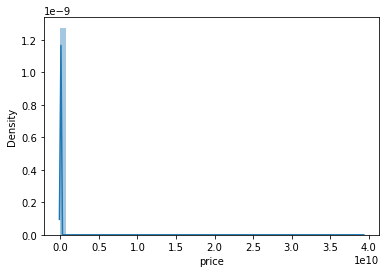

In [48]:
sns.distplot(train['price'])

#### Isolation Forest on Price, Price per Sqft, cc_distance, mrt distance, primary school distance, secondary school distance, shop distance

In [49]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft
0,HDB 4 ROOMS,99-year leasehold,1988,3,2,1115,unfurnished,5,116,1.414399,...,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329,461.434978
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,1.372597,...,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000
2,CONDO,freehold,2022,4,6,3070,partial,5,56,1.298773,...,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648
3,CONDO,freehold,2023,3,2,958,partial,5,638,1.312364,...,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,1.273959,...,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066


In [50]:
outlierdata = train[['price','price_per_sqft','cc_distance','mrt_distance','primary_school_distance','secondary_school_distance','shop_distance']]

In [51]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(max_samples='auto', contamination=float(0.15))
model.fit(outlierdata)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.15)

In [52]:
train['scores_price']=model.decision_function(outlierdata)
train['anomaly_price']=model.predict(outlierdata)

In [53]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,scores_price,anomaly_price
0,HDB 4 ROOMS,99-year leasehold,1988,3,2,1115,unfurnished,5,116,1.414399,...,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329,461.434978,-0.036305,-1
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,1.372597,...,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000,0.060666,1
2,CONDO,freehold,2022,4,6,3070,partial,5,56,1.298773,...,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648,0.011875,1
3,CONDO,freehold,2023,3,2,958,partial,5,638,1.312364,...,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349,0.052776,1
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,1.273959,...,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066,0.030116,1


In [54]:
anomaly=train.loc[train['anomaly_price']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

             property_type             tenure  built_year  num_beds  \
0              HDB 4 ROOMS  99-year leasehold        1988         3   
18                   CONDO  99-year leasehold        2017         4   
30               APARTMENT           freehold        2023         3   
32          TERRACED HOUSE           freehold        1980         4   
35             HDB 4 ROOMS  99-year leasehold        2017         3   
...                    ...                ...         ...       ...   
20221             BUNGALOW  99-year leasehold        1977         5   
20235                CONDO  99-year leasehold        2027         2   
20236          HDB 5 ROOMS  99-year leasehold        1996         4   
20241  SEMI-DETACHED HOUSE           freehold        2025         6   
20243          HDB 2 ROOMS  99-year leasehold        1976         2   

       num_baths  size_sqft   furnishing  available_unit_types  \
0              2       1115  unfurnished                     5   
18             

In [55]:
train = train[train.anomaly_price != -1]

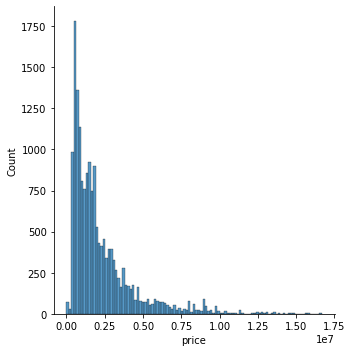

In [57]:
sns.displot(train['price'])

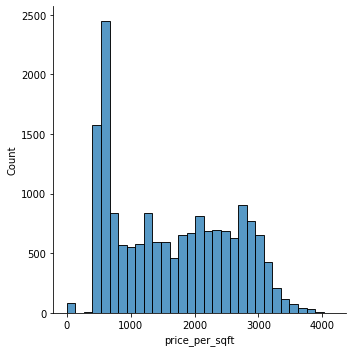

In [59]:
sns.displot(train['price_per_sqft'])

In [58]:
print("Skewness : %f" % train['price'].skew())
print("Kurtosis : %f" % train['price'].kurt())

Skewness : 2.226184
Kurtosis : 6.197214


In [62]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,available_unit_types,total_num_units,lat,lng,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,scores_price,anomaly_price
count,17216.000000,17216.000000,17216.000000,1.721600e+04,17216.000000,17216.000000,17216.000000,17216.000000,1.721600e+04,17216.000000,17216.000000,17216.000000,17216.000000,17216.000000,17216.000000,17216.000000,17216.000000,17216.000000,17216.0
mean,2011.480658,2.990416,2.461141,1.602504e+03,4.683260,363.959805,1.341192,103.843437,2.250176e+06,10.182145,8.712475,11.010977,9.813041,9.813041,17031.911013,1.798404,1656.019771,0.050427,1.0
std,15.527307,1.186070,1.285275,1.459023e+04,1.671893,300.299984,0.045725,0.051427,2.125313e+06,4.486803,4.498494,5.129336,4.168858,4.168858,16233.451826,1.531613,917.976654,0.022990,0.0
min,1963.000000,1.000000,1.000000,0.000000e+00,1.000000,4.000000,1.239621,103.686694,0.000000e+00,0.166654,0.027288,0.163496,0.455365,0.455365,0.000000,0.436400,0.000000,0.000002,1.0
25%,2002.000000,2.000000,2.000000,7.750000e+02,4.000000,160.000000,1.308696,103.806996,8.064000e+05,6.968761,5.094119,7.166768,6.420769,6.420769,4370.000000,1.061900,691.324555,0.033222,1.0
50%,2017.000000,3.000000,2.000000,1.076000e+03,5.000000,296.000000,1.329511,103.843027,1.575000e+06,10.324064,8.258901,10.924312,9.744595,9.744595,10840.000000,1.432900,1585.678089,0.051996,1.0
75%,2023.000000,4.000000,3.000000,1.389000e+03,6.000000,455.000000,1.373502,103.879948,2.857800e+06,12.721951,12.178054,14.753197,13.164897,13.164897,24760.000000,2.206800,2448.848684,0.068522,1.0
max,2028.000000,10.000000,10.000000,1.496000e+06,10.000000,2612.000000,1.461582,103.987450,1.667400e+07,24.886221,22.877877,29.078982,21.603775,21.603775,60670.000000,8.405500,4155.752212,0.101207,1.0


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


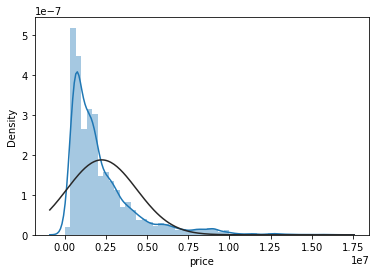

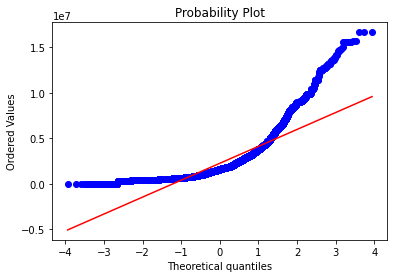

In [63]:
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler


sns.distplot(train['price'], fit = norm)
fig = plt.figure()
res = stats.probplot(train['price'],plot = plt)

In [ ]:
# train.describe()

In [ ]:
train = train.drop(columns='scores_price')
train = train.drop(columns='anomaly_price')

## Data Visualization after cleaning

#### built_year

In [ ]:
bins = train['built_year'].max() - train['built_year'].min()
plt.hist(train['built_year'], bins=bins, edgecolor='black')
plt.title('Distribution of Built Year')
plt.show()

#### 

#### Planning_area Housing price

In [ ]:
# Visualization
fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80)

# Find the order
my_order = train.groupby(by=["planning_area"])["price"].mean().sort_values(ascending=False).index

box_plot = sns.boxplot(x = 'subzone',y = 'price',data = train, order=my_order)
plt.ylabel('Price')
plt.xlabel('planning area')
plt.title('Planning Area housing price range comparison', fontsize=15, fontweight='bold', fontfamily='serif')

ax = box_plot.axes

lines = ax.get_lines()
#categories = ax.get_xticks()
ax.tick_params(axis='x', rotation=90)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4) 

box_plot.figure.tight_layout()

#fig = box_plot.get_figure()

#### Coorelation Matrix

In [ ]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr())
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
train.corr()['price'].sort_values()[:-1].plot(kind='bar')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.distplot(train['price'], kde=True, bins=200)
plt.show()